In [1]:
import pandas as pd
import pymssql
from datetime import datetime, date 

import numpy as np
from numpy import log
from prophet import Prophet

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from prophet.plot import add_changepoints_to_plot
import itertools

import holidays
import time
import urllib
import sqlalchemy as sa
import pyodbc

import random
from IPython.display import clear_output
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import pickle

/home/aaqil/aaqil_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [37]:
def get_data():
    try:
        con = pymssql.connect(user='username',password = 'password'
                 ,host='server',database='db',autocommit = True)
    except Exception as e:
        print('unable to connnect',e)
    cur=con.cursor()
    
    query="""
           IF OBJECT_ID('TEMPDB..#CLAIMS') IS NOT NULL
DROP TABLE #CLAIMS
SELECT CONVERT(DATE,C.DOS) AS DOS,CLAIM_NO INTO #CLAIMS FROM CLAIMS AS C
JOIN PATIENT AS P ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT
JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
WHERE ISNULL(C.DELETED,0)=0 AND CONVERT(DATE,C.DOS) BETWEEN '01-01-2021' AND '12-10-2022'----6383824



---------------------------#CHARGES----------------------
IF OBJECT_ID('TEMPDB..#CHARGES') IS NOT NULL
DROP TABLE #CHARGES
SELECT C.Claim_No,CC.claim_charges_id,CC.Amount INTO #CHARGES FROM Claim_Charges AS CC
JOIN #CLAIMS AS C ON CC.Claim_No=C.Claim_No
WHERE ISNULL(CC.DELETED,0)=0------



---------------------------------------------------------
SELECT CONVERT(DATE,C.DOS)AS DOS,COUNT(DISTINCT C.Claim_No) AS CLAIM_COUNT,SUM(CC.Amount) AS CHARGES_SUM FROM #CLAIMS AS C LEFT JOIN #CHARGES AS CC
ON C.Claim_No=CC.Claim_No
GROUP BY CONVERT(DATE,C.DOS)
ORDER BY CONVERT(DATE,C.DOS) ASC;
            """
     
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
        cur.close
        con.close
        return df
    except Exception as e:
        print('error in query',e)
        con.close()

In [38]:
df=get_data()

In [39]:
data=df.copy
df.columns
df.shape

(709, 3)

In [40]:
df.head()

,DOS,CLAIM_COUNT,CHARGES_SUM
0,2021-01-01,3110,935070.6400
1,2021-01-02,2496,631497.8700
2,2021-01-03,1844,453979.0600
3,2021-01-04,16669,4286450.1700
4,2021-01-05,16021,4165915.1300


In [41]:
df['DOS']=pd.to_datetime(df['DOS'])

In [42]:
claim_data=df[['DOS','CHARGES_SUM']]

In [46]:
# claim_data.isna

In [44]:
claim_data.CHARGES_SUM.mean()

3116619.7664047955

In [30]:
# # print(claim_data[claim_data['PAYMENTS']<0].replace(1560087.9600))
# y=claim_data.PAYMENTS.mean()
# print(type(y))
# claim_data.PAYMENTS=claim_data.PAYMENTS.apply(lambda x: y if x<0 else x)
# claim_data.PAYMENTS=claim_data.PAYMENTS.apply(lambda x: y if x>3000000 else x)

In [31]:
# claim_data.PAYMENTS.max()

In [32]:
type(claim_data.CHARGES_SUM)

pandas.core.series.Series

In [45]:
claim_data.CHARGES_SUM = claim_data.CHARGES_SUM.apply(int)

In [ ]:
# df[['CHARGES_SUM']].apply(int)

In [47]:
claim_data.head()

,DOS,CHARGES_SUM
0,2021-01-01,935070
1,2021-01-02,631497
2,2021-01-03,453979
3,2021-01-04,4286450
4,2021-01-05,4165915


In [48]:
claim_data = claim_data.rename(columns={'DOS': 'ds','CHARGES_SUM': 'y'})

In [49]:
# claim_data[['y']].astype(int)

In [50]:
claim_data['ds'] = pd.DatetimeIndex(claim_data['ds'])

In [51]:
claim_data.set_index('ds',inplace=True)

In [52]:
train=claim_data.loc[:'09-30-2022']
test=claim_data.loc['10-01-2022':]

In [53]:
train.reset_index(inplace=True)
train.head(10)

,ds,y
0,2021-01-01,935070
1,2021-01-02,631497
2,2021-01-03,453979
3,2021-01-04,4286450
4,2021-01-05,4165915
5,2021-01-06,4247366
6,2021-01-07,4182960
7,2021-01-08,3318481
8,2021-01-09,756810
9,2021-01-10,474888


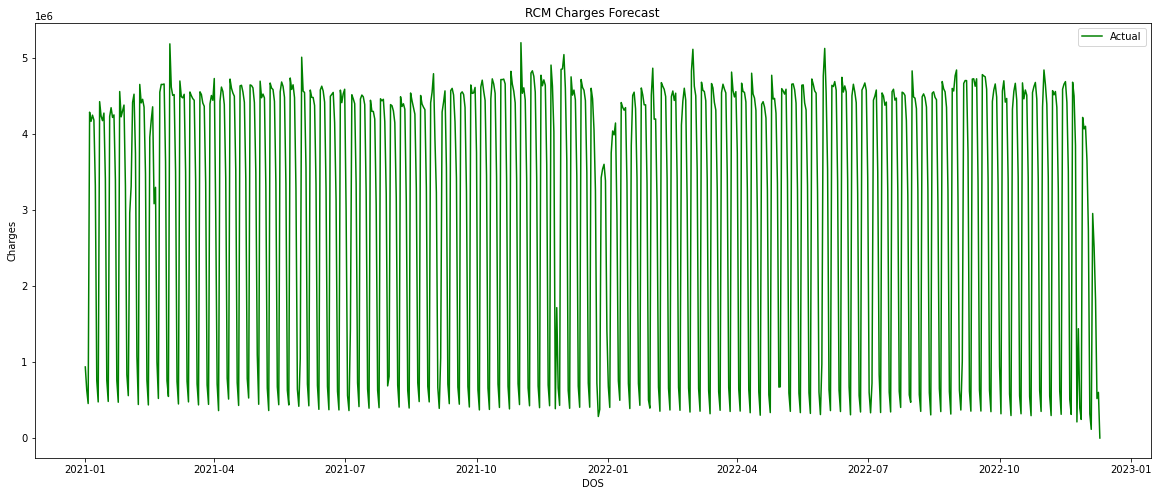

In [54]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(claim_data
         ,color='g', label='Actual')
plt.xlabel("DOS")
plt.ylabel("Charges")
plt.title("RCM Charges Forecast")
plt.legend(loc='upper right')
plt.show()

In [55]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [56]:
test_fc=test.reset_index()
test_fc.head()

,ds,y
0,2022-10-01,943613
1,2022-10-02,318828
2,2022-10-03,4564963
3,2022-10-04,4699388
4,2022-10-05,4418471


In [57]:
train_fc=train.set_index('ds')#.loc['01-01-2020':]
train_fc=train_fc.reset_index()
train_fc.head()

,ds,y
0,2021-01-01,935070
1,2021-01-02,631497
2,2021-01-03,453979
3,2021-01-04,4286450
4,2021-01-05,4165915


### Hyperparameter Tuning

In [58]:
my_model = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,)

In [59]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[10,15,20],
              'n_changepoints' : [25,50,75,100,125]
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [60]:
future_dates=pd.DataFrame(test_fc['ds'])
future_dates
model_parameters = pd.DataFrame(columns = ['mape','me','rmse','Parameters'])
cnt=1
for p in grid:
    clear_output(wait=True)
    print('Running at: ',cnt)
    cnt+=1
    test = pd.DataFrame()
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         holidays=holiday, 
#                          daily_seasonality=True,
#                          yearly_seasonality=True,
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(train)
    train_forecast = train_model.predict(future_dates)
    fc=train_forecast[['ds','yhat']]
    me = me = np.mean(fc.yhat - test_fc.y)
    mape=np.mean(np.abs(fc.yhat - test_fc.y)/np.abs(test_fc.y)) 
    rmse=rmse = np.mean((fc.yhat - test_fc.y)**2)**.5
    model_parameters = model_parameters.append({'mape':mape,'me':me,'rmse':rmse,'Parameters':p},ignore_index=True)
    

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


Running at:  150


INFO:cmdstanpy:finish chain 1


In [61]:
md=model_parameters.copy()
md['me']=abs(md['me'])
md.sort_values(by=['rmse'],ascending=True).iloc[0]['Parameters']


{'changepoint_prior_scale': 0.2,
 'holidays_prior_scale': 20,
 'n_changepoints': 25,
 'seasonality_mode': 'additive'}

In [62]:
#best rmse vale
{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 20,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

#best mape value
{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 10,
 'n_changepoints': 50,
 'seasonality_mode': 'additive'}

my_model1 = Prophet(changepoint_prior_scale = 0.2,
                     holidays_prior_scale = 20,
                     n_changepoints = 25,
                     seasonality_mode = 'additive',
                     weekly_seasonality=True,
#                      daily_seasonality=True,
#                      yearly_seasonality=True,
                     holidays=holiday,
                     interval_width=0.95)

In [63]:
my_model1.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [64]:
filename = 'RCM_Prophet_Overall_Billing_Charges.sav'
pickle.dump(my_model1, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

date_range=pd.date_range(start = '09-01-2022', end = '12-15-2022')
future_dates=pd.DataFrame(date_range,columns=['ds'])


forecast_outsample = loaded_model.predict(future_dates)
forecast_outsample[['ds', 'yhat']].tail()

,ds,yhat
101,2022-12-11,462892.61029
102,2022-12-12,4538944.69324
103,2022-12-13,4551446.58839
104,2022-12-14,4523472.80228
105,2022-12-15,4401429.19378


In [65]:
test=claim_data.loc['09-01-2022':'12-15-2022']

future_dates=pd.DataFrame(test.reset_index()['ds'])
future_dates

date_range=pd.date_range(start = '09-01-2022', end = '12-15-2022')
fd=pd.DataFrame(date_range,columns=['ds'])
test.tail()

,y
ds,
2022-12-06,2505193
2022-12-07,1813334
2022-12-08,519261
2022-12-09,600698
2022-12-10,25


In [66]:
forecast_outsample = my_model1.predict(fd)
forecast_outsample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50)


,ds,yhat,yhat_lower,yhat_upper
0,2022-09-01,4389694.62406,3624997.86780,5077824.93824
1,2022-09-02,3338888.72680,2634376.20506,4060526.04356
2,2022-09-03,737995.42684,33986.73439,1438704.51245
3,2022-09-04,451940.34522,-215306.54000,1098748.54564
4,2022-09-05,3043827.09365,2361945.26879,3734142.32047
5,2022-09-06,4540494.32332,3835973.68385,5238212.46826
6,2022-09-07,4512520.53721,3814939.40742,5223269.44695
7,2022-09-08,4390476.92871,3675868.81105,5052762.20964
8,2022-09-09,3339671.03145,2629077.86458,4080243.66794
9,2022-09-10,738777.73149,21623.14496,1494210.23901


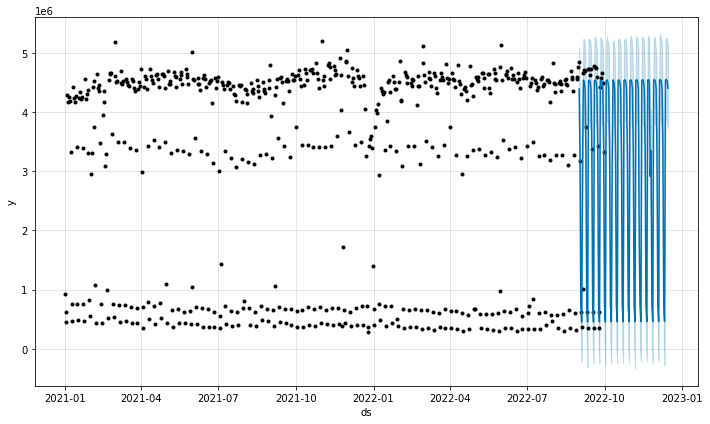

In [67]:
fig=my_model1.plot(forecast_outsample, uncertainty=True)

In [68]:
fc=forecast_outsample[['ds','yhat']]
fc.set_index('ds',inplace=True)
fc.head()

,yhat
ds,
2022-09-01,4389694.62406
2022-09-02,3338888.72680
2022-09-03,737995.42684
2022-09-04,451940.34522
2022-09-05,3043827.09365


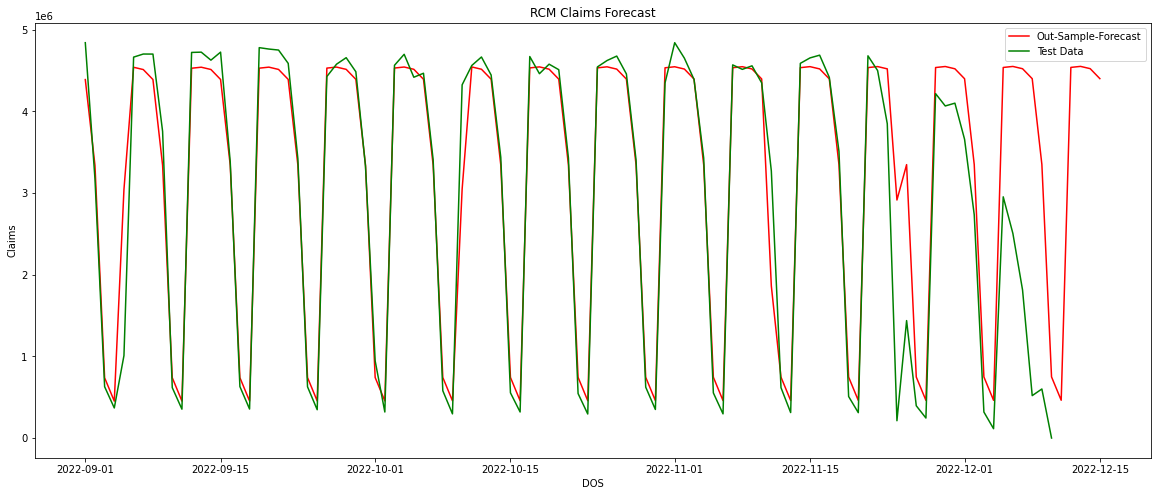

In [69]:
plt.rcParams["figure.figsize"] = (20,8)
#plt.plot(train.set_index('ds'),color='y', label='Train Data')
#plt.plot(tc,color='b', label='In-Sample-Forecast')
plt.plot(fc,color='r', label='Out-Sample-Forecast')
plt.plot(test,color='g', label='Test Data')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [70]:
# print('ME Out Sample Forecast: ',np.mean(fc.values-test.values))

# print('RMSE Out Sample Forecast: ',np.mean((fc.yhat - test.y)**2)**.5 )

# print('MAPE: ',np.mean(np.abs(fc.yhat - test.y)/np.abs(test.y)))

In [71]:
d=pd.merge(
    forecast_outsample[['ds', 'yhat']],
    test.reset_index(),
    how="left",
    on=['ds'],
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
d['diff']=abs(d['yhat']-d['y'])
#d.to_csv('prophet.csv')
d.head(50)

,ds,yhat,y,diff
0,2022-09-01,4389694.62406,4841466.00000,451771.37594
1,2022-09-02,3338888.72680,3173848.00000,165040.72680
2,2022-09-03,737995.42684,628480.00000,109515.42684
3,2022-09-04,451940.34522,368385.00000,83555.34522
4,2022-09-05,3043827.09365,1009623.00000,2034204.09365
5,2022-09-06,4540494.32332,4664799.00000,124304.67668
6,2022-09-07,4512520.53721,4702600.00000,190079.46279
7,2022-09-08,4390476.92871,4702058.00000,311581.07129
8,2022-09-09,3339671.03145,3755329.00000,415657.96855
9,2022-09-10,738777.73149,617133.00000,121644.73149


In [72]:
predicted=d['yhat'].sum()
original=d['y'].sum()

print(predicted,original)


(original/predicted)*100
# (predicted/original)*100

336532657.94629806 298226302.0


88.61734365393723

In [73]:
original-predicted

-38306355.94629806

In [ ]:
# data_to_dump=d[['yhat','ds']]
# data_to_dump['PRACTICE_CODE']=0
# data_to_dump['FORECAST_TYPE']='Overall_Billing_Charges'
# data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)
# DUMP_DATA(data_to_dump)

In [ ]:
# def DUMP_DATA(data_assigned):
#     if(data_assigned.shape[0]>0):
        
#         params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};"
#                                  "SERVER=172.16.0.66;"
#                                  "DATABASE=DS_TEST;"
#                                  "UID=datascience;"
#                                  "PWD=mtbc@1234")

#         engine = sa.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params),fast_executemany=True) 
#         data_assigned.to_sql(name='DS_RCM_Forecasting',con=engine,index=False,if_exists='append')
#         engine.dispose()
#         print('DATA DUMPED')
#         return 0

In [ ]:
# def DUMP_DATA(d,forecast_section,pracice_code):
#     data_to_dump=d[['yhat','ds']]
#     data_to_dump['PRACTICE_CODE']=pracice_code
#     data_to_dump['FORECAST_TYPE']=forecast_section
#     data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)

#     con = pymssql.connect(user='mtbcweb',password = 'mtbcweb@mtbc'
#                          ,host='172.16.0.168',database='AmazingDb',autocommit = True)
#     cur=con.cursor()
#     for i, row in data_to_dump.iterrows():
#         query="""
#             insert into DS_RCM_Forecasting(practice_code,forecasted_value,Forecast_date,Forecast_section)
#         values(%s,%s,%s,%s)
#             """
#         cur.execute(query, (row['PRACTICE_CODE'],row['FORECASTED_VALUE'],row['FORECAST_DATE'],row['FORECAST_TYPE']))
#     print('Data Inserted')
#     con.close()

In [ ]:
# DUMP_DATA(d,'Overall_Billing_Charges', 0)